# Introduction

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Personalized unction library
from prepare_country_data import transpose_for_country_code, split_and_normalize, cyclical_transformation

# Prepare dataset

In [24]:
# Load complete dataset
df = pd.read_csv("data/2023/nordic_energy_data.csv")
# Apply transformations based on desired bidding zone
df_dk1 = transpose_for_country_code(df, "DK_1")
# Apply cyclical transformation to time
df_dk1 = cyclical_transformation(df_dk1)
# Chose desired time period
df_dk1['Timestamp'] = pd.to_datetime(df_dk1['Timestamp'])
df_dk1 = df_dk1[(df_dk1['Timestamp'].dt.month >= 8) & (df_dk1['Timestamp'].dt.month <= 11)]
# Apply split and normalization based on desired number of test days
X_train, X_test, y_train, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std = split_and_normalize(df_dk1, test_days=2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Convert to numpy arrays - relevant for some models
X_train_num = X_train.to_numpy()
X_test_num = X_test.to_numpy()
y_train_num = y_train.to_numpy()
y_test_num = y_test.to_numpy()

(2880, 92) (48, 92) (2880,) (48,)


# Temporal Model MMCA

In [25]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 

from prepare_country_data import transpose_for_country_code

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [26]:
x = pd.concat([X_train[2:], X_test])
y = pd.concat([y_train, y_test])
x = x.to_numpy()
y = y.to_numpy()
N,D = x.shape
T = len(y_train) + len(y_test)
print("T=%d" % (T))
print("N=%d, D=%d" % (N,D))


x_mean = X_train_mean
x_std = X_train
y_true_mean = y_train_mean
y_true_std = y_train_std



T=2928
N=2926, D=92


In [27]:
#make ix_mis1 be the last 2000 indexes from x
ix_mis1 = np.arange(T - len(y_test), T)
ix_obs1 = np.arange(T - len(y_test))

T_mis = len(ix_mis1)
T_obs = len(ix_obs1)
T = T_obs + T_mis
print("T_obs:", T_obs)
print("T_mis:", T_mis)


T_obs: 2880
T_mis: 48


In [28]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    B1, B2, W, h_prev1, h_prev2, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = B1*h_prev1 + B2*h_prev2 + jnp.matmul(W, x_t) + tau*noise_t
    h_prev1 = h_t
    h_prev2 = h_prev1
    
    return (B1,B2, W, h_prev1,h_prev2, tau), h_t

In [29]:
def model(T, T_forecast, x_t, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    B1 = numpyro.sample("B1", dist.Normal(loc=0., scale=1.))
    B2 = numpyro.sample("B2", dist.Normal(loc=0., scale=1.))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros(D), scale=jnp.ones(D)))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=.1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev1 = numpyro.sample("z_1", dist.Normal(loc=0., scale=.1))
    h_prev2 = numpyro.sample("z_2", dist.Normal(loc=0., scale=.1))

    noises_t = numpyro.sample("noises_t", dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))

    # Propagate the dynamics using jax.lax.scan
    carry = (B1,B2, W, h_prev1,h_prev2, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev1, h_prev2]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-2)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    # Sample observed and missing values
    #numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_mis", dist.Normal(loc=h_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_obs", dist.Normal(loc=h_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    return h_collection

In [30]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=0, x_t=x, obs=y, ix_mis=ix_mis1, ix_obs=ix_obs1)

sample: 100%|██████████| 2000/2000 [13:52<00:00,  2.40it/s, 1023 steps of size 2.50e-04. acc. prob=0.95]


In [31]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
            B1      0.75      0.35      0.84      0.21      1.24      4.87      1.38
            B2     -0.06      0.35     -0.16     -0.55      0.50      4.84      1.38
          W[0]      0.23      0.01      0.23      0.23      0.24      4.46      1.43
          W[1]      0.16      0.01      0.16      0.15      0.17      7.03      1.08
          W[2]     -0.06      0.01     -0.06     -0.07     -0.05      5.43      1.25
          W[3]     -0.09      0.00     -0.09     -0.09     -0.08      8.12      1.20
          W[4]     -0.16      0.01     -0.16     -0.17     -0.15      7.25      1.17
          W[5]     -0.01      0.00     -0.01     -0.01     -0.01      9.68      1.03
          W[6]      0.02      0.00      0.02      0.01      0.02      7.68      1.00
          W[7]     -0.04      0.00     -0.04     -0.05     -0.04      4.51      1.19
          W[8]      0.02      0.01      0.02      0.01      0.03

In [32]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


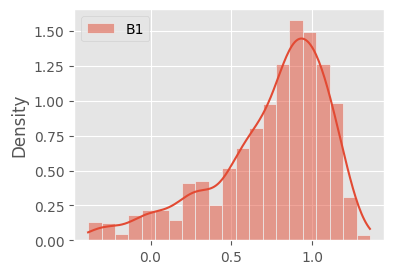

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


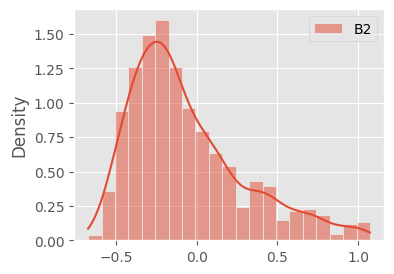

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


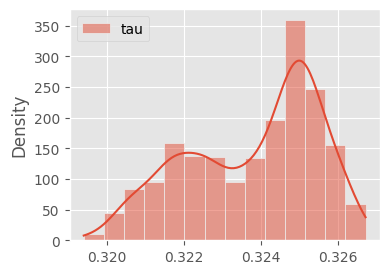

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


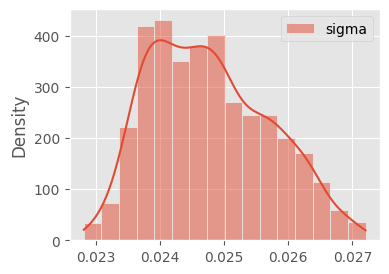

In [33]:
nodes = ["B1","B2", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()

In [34]:
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

In [35]:
predictions_temporal_MMCA = y_hat * y_true_std + y_true_mean

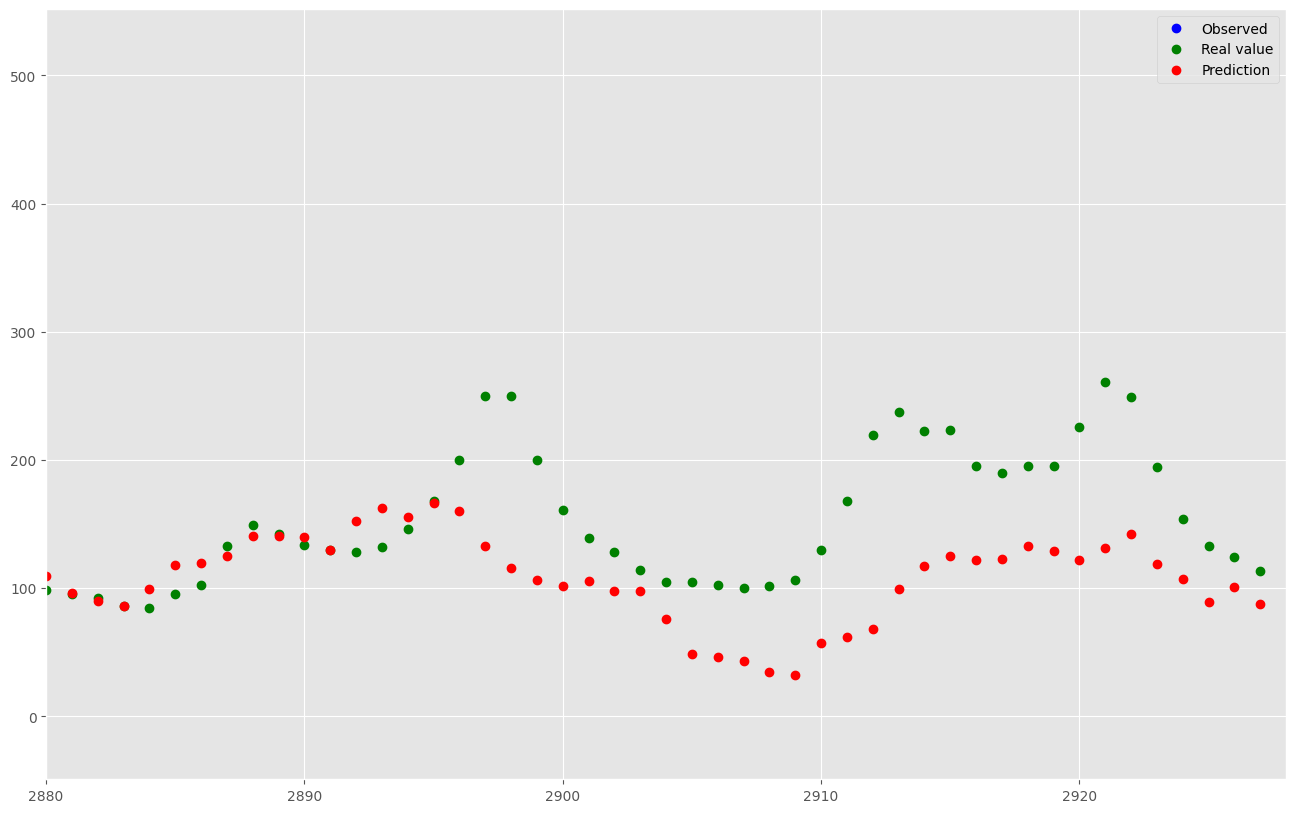

In [36]:
y_obs1 = y[ix_obs1]
y_mis1 = y[ix_mis1]

plt.plot(ix_mis1, (y_mis1*y_true_std) + y_true_mean, "go")
plt.plot(ix_mis1, (y_hat*y_true_std) + y_true_mean, "ro")
plt.xlim([T - len(y_test), T])
plt.legend(["Real value", "Prediction"])

In [37]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [38]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.411
MAE: 1.03717
RMSE: 1.33483
R2: 0.000


# Temporal Model SVI

# Simple Gaussian Model

In [39]:
# Define Covariance functions
def covSE(x1, x2, cov_params=[2.0]):
    return np.exp(-cov_params[0]*np.sum((x1 - x2)**2))

def covPER(x1, x2, cov_params):
    return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))

def covWN(x1, x2, cov_params):
    if x1.any() == x2.any():
        return cov_params[0]
    else:
        return 0

def cov(x1, x2, cov_fn, cov_params):
    K = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i,j] = cov_fn(x1[i,:], x2[j,:], cov_params)
    return K

def covSUM_WN_SE(x1, x2, cov_params):
    K = covWN(x1, x2, cov_params[:1]) + covSE(x1, x2, cov_params[1:])
    return K

def covSUM_PER_SE(x1, x2, cov_params):
    return covPER(x1, x2, cov_params[:3]) + covSE(x1, x2, cov_params[3:])

def make_and_plot_cov(X, cov_func, cov_params):

    # construct K
    K = cov(X, X, cov_func, cov_params)
    plt.imshow(K)
    plt.title("Covariance matrix from Gaussian process prior")
    plt.show()
    return K

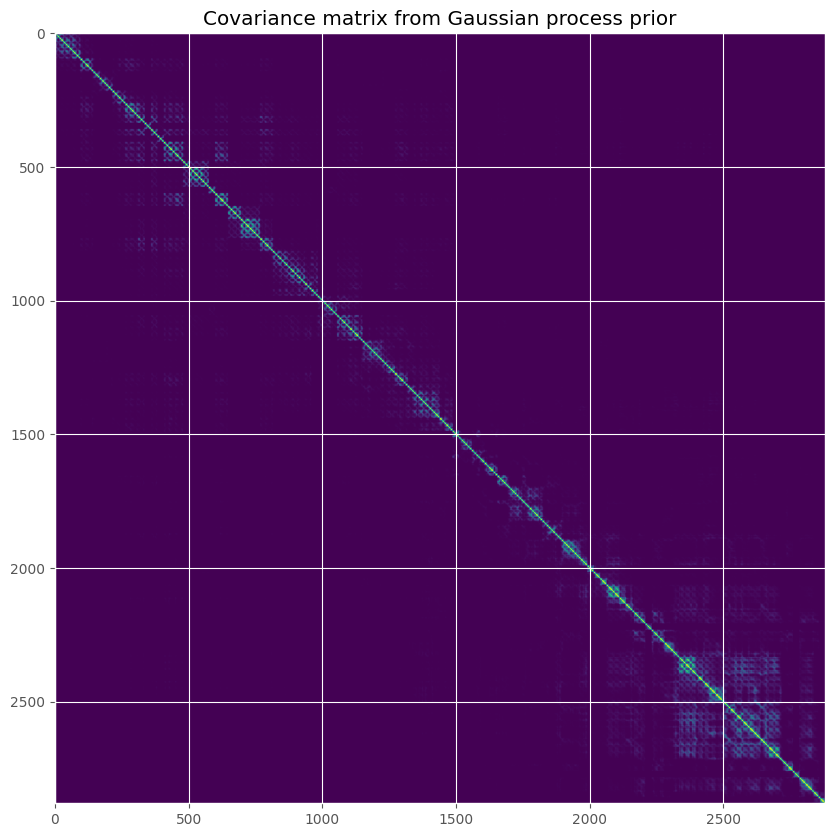

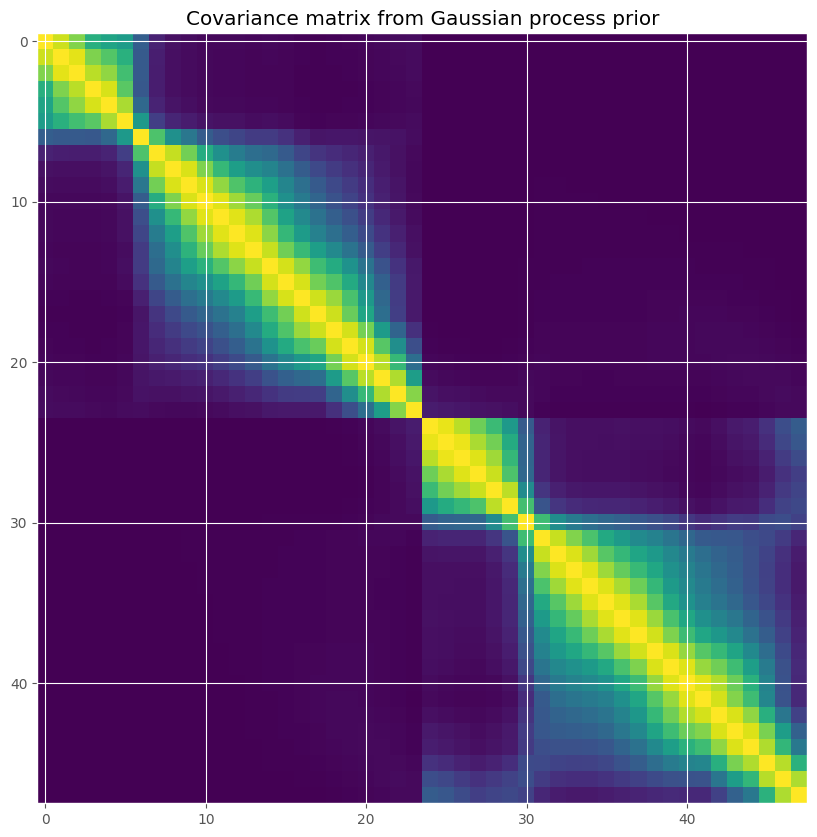

In [40]:
# Plot covariance matrices K and K_star_star
K = make_and_plot_cov(X_train_num, covSE, [0.05])
K = make_and_plot_cov(X_test_num, covSE, [0.1])

In [41]:
# Function to compute the predictive posterior
def compute_predictive_posterior(X_test_num, X_train_num, sigma, cov_params):
    N_test = len(X_test_num)

    predictions_gp = np.zeros(N_test)
    variances = np.zeros(N_test)
    
    K = cov(X_train_num, X_train_num, covSUM_PER_SE, cov_params)
    k_star = cov(X_train_num, X_test_num, covSUM_PER_SE, cov_params)
    k_star_star = cov(X_test_num, X_test_num, covSUM_PER_SE, cov_params)
    
    mean = k_star.T @ np.linalg.inv(sigma**2*np.eye(X_train_num.shape[0]) + K) @ y_train_num
    std = k_star_star + sigma**2 - k_star.T @ np.linalg.inv(sigma**2 * np.eye(X_train_num.shape[0]) + K) @ k_star

    predictions_gp =  np.random.multivariate_normal(mean.squeeze(), std)

    variances = np.diag(std)
    
    return predictions_gp, variances, mean, std, K

# Define parameters
cov_params = [1, 0.05, 2, 0.0001] # relatively good for PER_SE

sigma = 0.01
# Run model
predictions_gp, variances, mean, std, K = compute_predictive_posterior(X_test_num, X_train_num, sigma, cov_params)

Mean squared error: 0.765692988865407
Root mean squared error: 0.8750388499177663
Mean absolute error: 0.6651197544594837


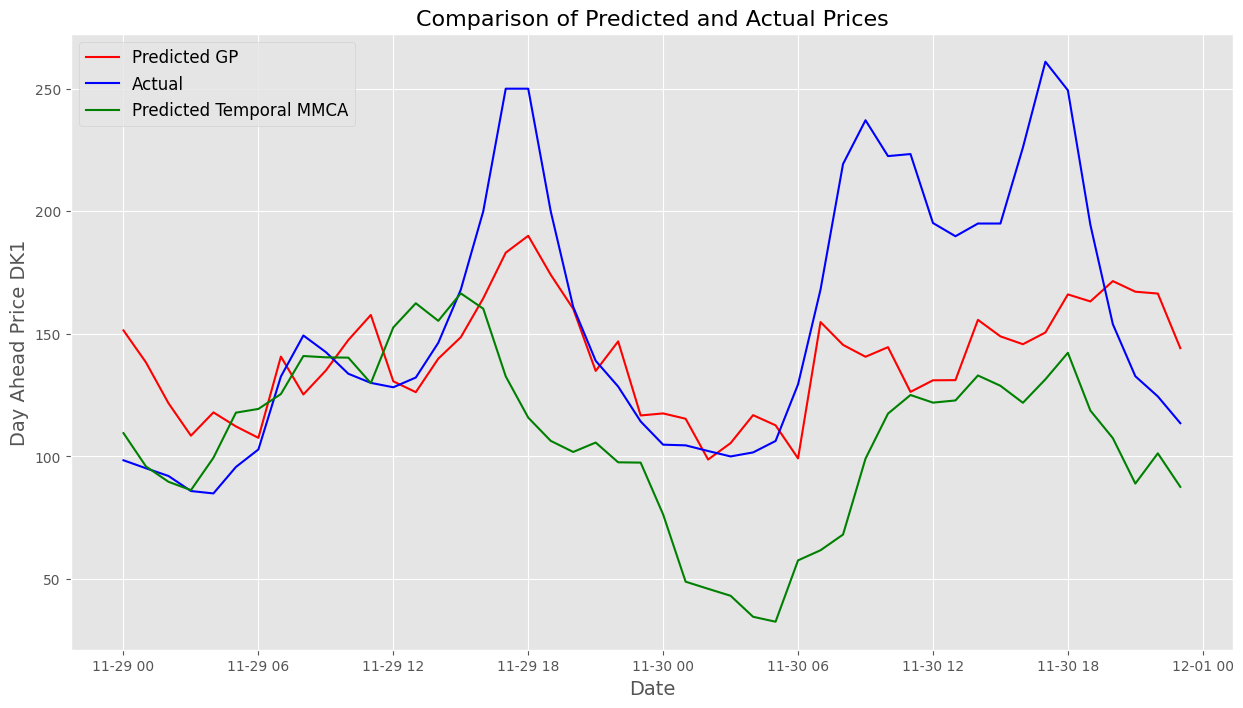

In [42]:
# print error measures
mse = mean_squared_error(y_test_num, predictions_gp)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_num, predictions_gp)
print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")
print(f"Mean absolute error: {mae}")

# Plot results
plt.figure(figsize=(15, 8))
predictions_gp_std = (predictions_gp * y_train_std) + y_train_mean
y_test_num_std = (y_test_num * y_train_std) + y_train_mean

plt.plot(y_test.index, predictions_gp_std, label="Predicted GP", color="red")
plt.plot(y_test.index, y_test_num_std, label="Actual", color="blue")
plt.plot(y_test.index, predictions_temporal_MMCA, label="Predicted Temporal MMCA", color="green")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Day Ahead Price DK1", fontsize=14)
plt.title("Comparison of Predicted and Actual Prices", fontsize=16)
plt.legend(fontsize=12)
plt.show()


### Estimating the most important features

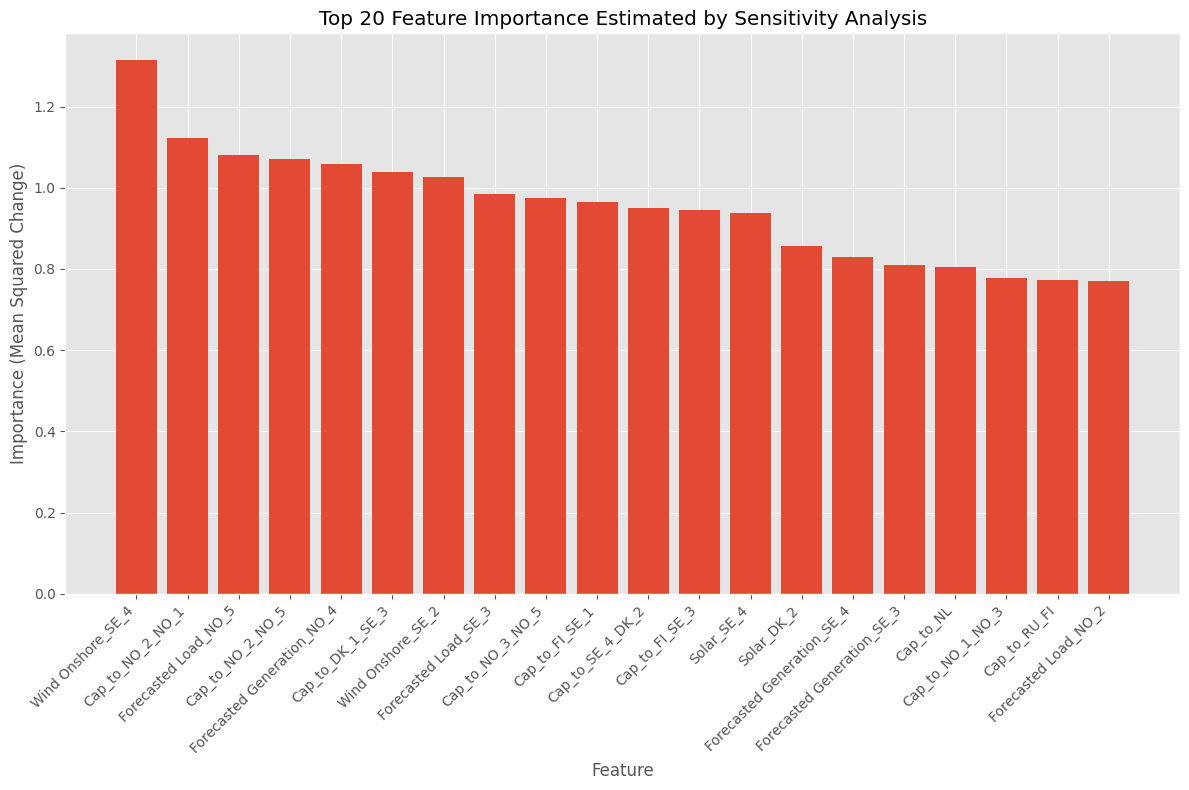

In [44]:
def compute_predictive_posterior_wo_computing_K(X_test_num, X_train_num, K, sigma, cov_params):
    N_test = len(X_test_num)

    predictions_gp = np.zeros(N_test)
    
    k_star = cov(X_train_num, X_test_num, covSUM_PER_SE, cov_params)
    k_star_star = cov(X_test_num, X_test_num, covSUM_PER_SE, cov_params)
    
    mean = k_star.T @ np.linalg.inv(sigma**2*np.eye(X_train_num.shape[0]) + K) @ y_train_num
    std = k_star_star + sigma**2 - k_star.T @ np.linalg.inv(sigma**2 * np.eye(X_train_num.shape[0]) + K) @ k_star

    predictions_gp =  np.random.multivariate_normal(mean.squeeze(), std)
    
    return predictions_gp

def feature_importance(baseline_pred, X_test_num,X_train_num, K, feature_names, sigma, cov_params, epsilon=0.01):
    
    importances = np.zeros(X_test_num.shape[1])
    
    # Iterate over each feature
    for i in range(X_test_num.shape[1]):
        X_perturbed = np.copy(X_test_num)
        std_dev = np.std(X_test_num[:, i])
        
        # Perturb the feature
        X_perturbed[:, i] += epsilon * std_dev
        
        # Predict with perturbed data
        #perturbed_pred = gp.predict(X_perturbed)
        perturbed_pred = compute_predictive_posterior_wo_computing_K(X_perturbed, X_train_num, K, sigma, cov_params)
        
        # Calculate the mean squared difference
        importances[i] = np.mean((perturbed_pred - baseline_pred) ** 2)
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = [feature_names[i] for i in indices]
    
    return sorted_importances, sorted_feature_names

# Feature names from the DataFrame
feature_names = X_train.columns.tolist()

# Calculate feature importances
sorted_importances, sorted_feature_names = feature_importance(predictions_gp, X_test_num,X_train_num, K, feature_names, sigma, cov_params, epsilon=0.01)

# Select the top 20 features
top_features = sorted_importances[:20]
top_feature_names = sorted_feature_names[:20]

# Plotting the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.bar(top_feature_names, top_features)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Feature')
plt.ylabel('Importance (Mean Squared Change)')
plt.title('Top 20 Feature Importance Estimated by Sensitivity Analysis')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

# PPCA